# Introduction to Ensembling/Stacking in Python
---
https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook   
캐글 필사 스터디를 진행하면서 기존에 작성된 코드 및 설명을 필사한다.   

## Introduction
이 노트북은 모델들을 앙상블하는 방법에 대한 아주 기본적이고 간단한 입문서이며, 특히 Stacking으로 알려진 다양한 앙상블 기법이다. 간략히 애기하면 Stacking은 **몇 가지 기본적인 분류기의 예측값을 사용한(first-level) 다음 first-level로부터 예측한 값으로 output을 예측하기 위해 다른 모델를 사용한다(second-level).**

Titanic dataset은 캐글을 시작하는 많은 임문자들에게 Stacking의 개념을 도입하기 위한 중요한 후보이다. 게다가 Stacking이 캐글 대회에서 많은 팀들의 우승의 원인이였지만, 이 주제에 대한 커널들이 부족해 보인다. 그래서 이 노트북이 부족한 것들을 채워 주길 바란다.

나 자신도 Kaggle scene에서 꽤 신입이고, 우연히 발견하고 연구하여 처음으로 적절하게 작성한 Ensembling/Stacking script는 Faron이 AllState Severity Claims competition 작성된 것이다. **이 노트북 자료는 Faron의 script를 많이 차용했지만, Faron의 regressor of ensemble를 classifier of ensemble로 변환하였다.** 어쨋든 Faron의 script는 여기서 확인해라.  
- [Stacking Starter](https://www.kaggle.com/code/mmueller/stacking-starter) : by Faron

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

일반화된 대부분의 커널 방법처럼 진행한다. 첫번째로 데이터를 탐구하고, 가능한 특징 엔지니어링 기회를 식별하고 어떤 범주형 특징들을 수치적으로 인코딩한다.

In [2]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 임무는 어떻게든 범주형 변수에서 정보를 추출하는 일이다.

### Feature Engineering

여기서, 특징 엔지니어링 아이디어를 포괄적이고 잘 고안해 놓은 Sina의 노트북을 확인하라.
- [Titanic Best Working Classfier](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier) : by Sina

In [3]:
full_data = [train, test]

# <-- Feature Engineering -->
# some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone From Family Size
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles fo passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# <-- Data Cleaning -->
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare' ] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare' ] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare' ] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare' ] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age' ] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age' ] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age' ] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age' ] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age' ] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

feature engineering, cleaning, drop categorical columns를 수행하면 모든 feature들은 숫자여야 하며 Machine Learning models에 먹이기에 적합한 포맷이어야 한다. 하지만 우리는 진행하기 이전에 변환된 데이터셋의 간단한 상관관계와 분포를 확인하겠다.
## Visualisations

In [5]:
train.head(3)
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


### Pearson Correlation Heatmap
하나의 특성이 다른 특성들과 얼마나 관련있느지 확인하기 위해 특징들의 상관관계를 그린다. 그렇게 하기위해, 우리는 heatmap을 펼리하게 그릴 수 있는 Seaborn plotting 패키지를 활용 할 것이다.

<AxesSubplot:title={'center':'Person Correlation of Features'}>

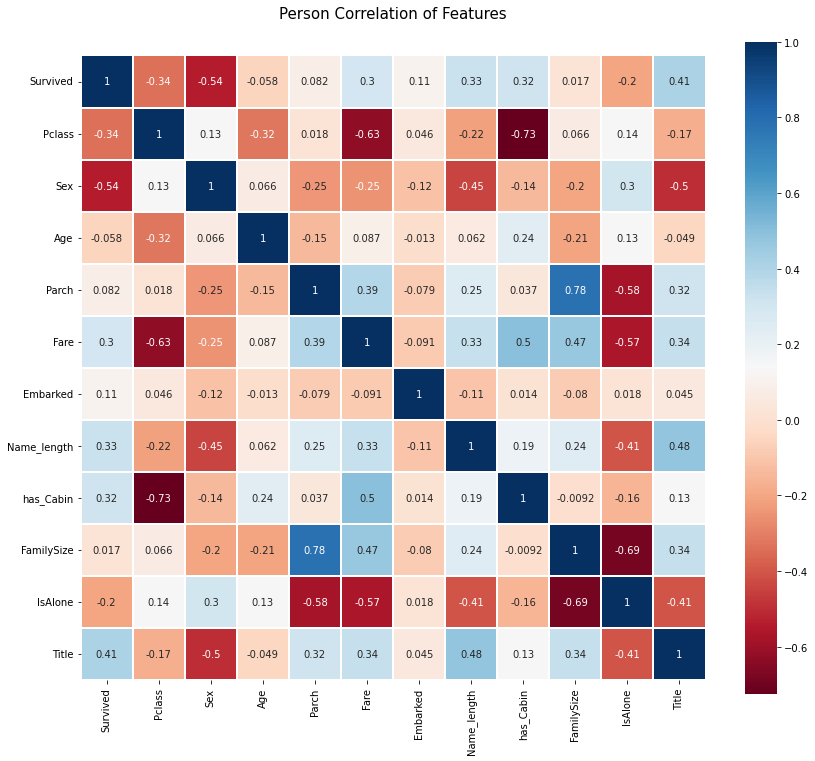

In [6]:
colormap = plt.cm.RdBu # colormap config
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots
Pearson Correlation plot를 보면 알 수 있는 사실은 서로 강하게 상관되는 많은 feature가 없다는 것이다. 이것은 train 데이터에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하고 각 특징에 고유한 정보가 포함되어 있다는 것이기 때문에 학습 모델에 특징을 제공하는 관점에서 좋다. 여기서 가장 상관관계가 큰 두 개의 특징은 Family size와 Parch 이다. 훈련의 목적을 위해 두 개의 특징을 그대로 둘 것이다.

### Pairplots
하나의 특징이 다른 것들에 데이터 분포를 관측하기 위해 pairplot를 사용한다.

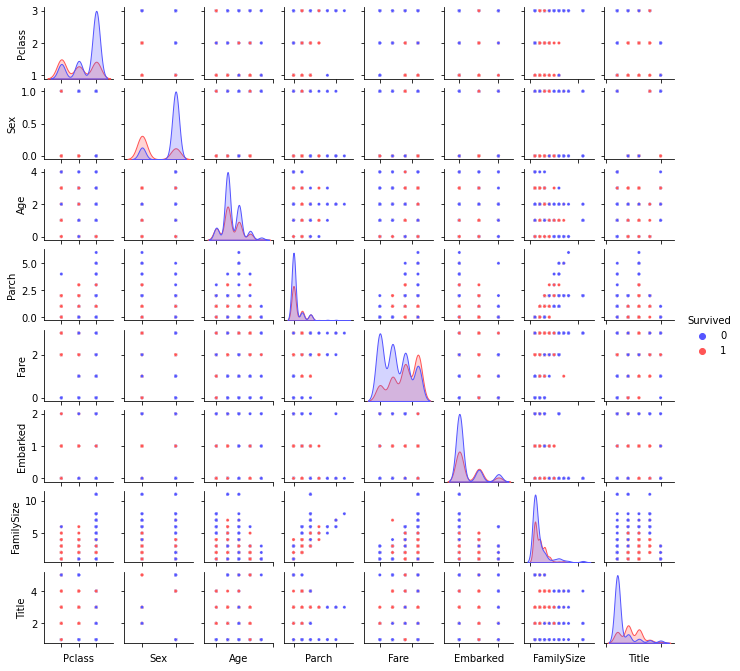

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, 
                diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models
feature engineering과 formatting을한 후, 우리는 이 노트북의 핵심에 도달했다.
Stacking ensemble 만들기!

### Helpers via Python Classes
우리는 파이썬 클래스를 호출하여 더 편리하게 만든다.

아래 코드에서, 우리는 기본적으로 모든 SKlearn Classifier에 공통적으로 내장되어있는 함수들을 사용하기위한 SklearnHelper class를 작성한다. 그러므로 5개의 다른 classifier를 호출하기 원한다면 같은 메소드를 반복적으로 사용하지 않아도 된다.

In [8]:
# Some useful parameters which will com in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
        
# Class to extend XGboost classifer

### Out-of-Fold Predictions
앞서 말한 것 처럼 Stacking은 기본 분류기의 예측을 second-level model 학습을 위해 입력으로 사용한다. 하지만, 모든 training data를 기본 모델에 학습하여 모든 test set의 예측값을 생성하고 이후 second-level 학습을 위해 output을 사용할 수 없다. 이것은 기본 모델들이 이미 test set을 본 상태가 되며 그러므로 예측에 오버피팅이 발생한다.

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
first level 분류로써 5개의 모델을 준비한다. 이 모델들은 SKlearn library를 통해 편리하게 사용할 수 있다.
1. Random forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

#### Parameters
파라미터들 설명  
**n_jobs** : 학습을 위해 사용되는 코어 수. 만약 설정이 -1면 모든 코어가 사용된다.  
**n_estimators** : 학습 모델 트리 분류기 개수(기본 10개)  
**max_depth** : 최대 트리 깊이 or 얼마나 노드를 확장할지. 너무 깊게하면 overfitting 될 수 있다.  
**verbose** : 학습 과정을 텍스트로 표현할지 안할지 조정. 0을 주면 보이지 않고, 3을주면 모든 반복 동작에 대해 보여줌  

In [10]:
# Put in our parameters for said classifiers
# Random Forest Parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    #'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [11]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Creating Numpy arrays out of our train and test sets
first level의 기존 모델들이 준비 됬다. 우리는 dataframe으로부터 Numpy arrays를 생성함으로써 분류기에 input으로 넣기 위한 train set과 test set을 준비할 수 있다.

In [12]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Create an array of the test data


#### Output of the First level Predictions

In [13]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


#### Feature importances generated from the different classifiers
우리는 Sklearn 모델의 매우 훌륭한 기능을 활용할 수 있다. 간단한 코드 한줄로 train과 test set에서 다양한 특징의 중요성을 뽑는다.

Sklearn documentation에 따르면, 대부분의 classifier들은 ***.feaureimportance***를 입력하여 중요한 특성을 리턴하는 속성이 내장 되어있다. 그러모르 우리는 함수를 통해 매우 유용한 속성을 호출하고 중요한 특징을 plot 할 것이다.

In [14]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12776837 0.20253939 0.03278805 0.02034571 0.07143473 0.02393504
 0.10964932 0.06470923 0.06535567 0.01381528 0.26765921]
[0.12050151 0.37752373 0.02827969 0.01709689 0.05658499 0.02828418
 0.04742747 0.08352984 0.04292561 0.02191955 0.17592656]
[0.03  0.01  0.018 0.064 0.032 0.008 0.712 0.01  0.048 0.004 0.064]
[0.08828468 0.00983946 0.05175517 0.01211984 0.0499557  0.02342256
 0.17768248 0.03653671 0.11063669 0.00545124 0.43431547]


나는 아직 특징 중요도를 할당하고 저장하느 방법을 파악하지 못했다. 따라서 위 코드에서 값을 프린트한 다음 아래와 Python 리스트로 copy and paste 한다.

In [15]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Plotly 패키지를 통해 쉽게 그리기위해 리스트에 포함된 특징 중요성 데이터를 DataFrame을 만든다.

In [16]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

#### Interactive feature importances via Plotly scatterplots
Plotly 패키지를 사용하여 "Scatter"라는 plotly scatter plot를 통해 다른 분류기들의 특징 중요도 값을 시각화한다.

In [17]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#         size= feature_dataframe['AdaBoost feature importances'].values,
#         color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

모든 중요도 특징의 평균을 계산하고, 특징 중요도 dataframe에 새로운 컬럼으로 저장한다.

In [18]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


#### Plotly Barplot of Average Feature Importances
모든 분류기에서 특징 중요도 평균을 얻었으니, 우리는 Plotly bar plot으로 그릴 수 있다.

In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output
#### First-level output as new features
first-level 예측을 얻었으므로, 이는 다음 분류기를 위한 train dataset으로 사용할 수 있는 새로운 특징 셋로 생각할 수 있다. 아래 코드를 보면, 우리는 우리의 초기 분류기로부터 새로운 컬럼으로 first-level 예측값을 가지고 있고 이것을 다음 분류기에 학습한다.

In [20]:
base_predictions_train = pd.DataFrame(
    {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second Level Training set

In [21]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x= base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

더 좋은 점수를 생산하는 서로 관련없는 학습된 모델들의 장점들에 대해 많은 기사와 Kaggle competiton winner들의 이야기들이 꽤 많다.

In [22]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

이제 first-level의 학습과 예측값 모듈을 x_train과 x_test로 연결하고 합쳤으므로, 우리는 second-level model에 학습할 수 있다.

#### Second level learning model via XGBoost
우리는 boosted tree learning model에 중에 유명한 라이브러리 XGBoost를 선택한다. 이것은 lage-scale boosted tree algorithms에 최적화 되어 있다. 알고리즘에 대한 더 나은 정보는 official document를 참고하라.

어째든, 우리는 XGBClassifier를 호출하고 first-level의 train와 target data를 학습하고 test data를 학습하기 위해 학습 모델을 사용한다.

In [23]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

#### Producing the Submission file
마지막으로 first-level과 second-level 모델들을 학습하여, 우리는 Titanic competition에 제출하기 위한 적절한 포맷으로 예측값을 뽑을 수 있다.

In [24]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

#### Steps for Further Improvement
마지막으로, 위에 보여진 step들은 단지 ensemble stacker를 만드는 간단한 방법을 보여주고 있는 것을 주목해야한다. 너는 2 level 이상의 stacking의 방법 뿐만아니라 여러 classifier들의 많은 조합을 사용하는 높은 level로 만들어진 ensemble들을 Kaggle competition들에서 들었을 것이다.

성능을 높이기 위해 몇몇 추가된 단계
1. 최적의 파라미터를 찾기 위한 모델을 훈련에 좋은 cross-validation 전략 구현
2. 학습하기위한 훌륭하고 다양한 base model 도입. 상관 관계가 더 없는 결과가 최종 점수에 더 좋다

#### Conclusion
이 노트북은 stacking 학습 모델을 위한 작업을 도입하는데 어느정도 도움이 되었다.